In [ ]:
import sys
sys.path.append('/home/s312657018/TBrain/code')

import pandas as pd
import glob
from itertools import combinations

import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import sys
sys.path.append('/home/s312657018/TBrain/code')
from dataset import process_serial
from Configs import Config

In [ ]:
data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/All_min_Training_Data.csv')

In [10]:
import pandas as pd
import numpy as np

def add_time_head_tail(train_data, datetime_col, station_col, head_time, tail_time, target_col):
    """
    为训练集添加每天的 time_head 和 time_tail 特征，并将这些值填充到当天的所有记录。
    :param train_data: 训练集 DataFrame
    :param datetime_col: 时间列名称
    :param station_col: 站点 ID 列名称
    :param head_time: 头部时间（例如 '07:00:00'）
    :param tail_time: 尾部时间（例如 '08:50:00'）
    :param target_col: 目标列名称（如 'Sunlight(Lux)'）
    :return: 包含 time_head 和 time_tail 的训练集
    """
    # 确保时间列为 datetime 格式
    train_data[datetime_col] = pd.to_datetime(train_data[datetime_col])
    
    # 提取日期
    train_data['Date'] = train_data[datetime_col].dt.date
    
    # 初始化存储结果的列
    train_data['time_head'] = np.nan
    train_data['time_tail'] = np.nan
    
    # 遍历每个站点 ID，找到每天的 time_head 和 time_tail
    for station_id in train_data[station_col].unique():
        station_data = train_data[train_data[station_col] == station_id]
        
        # 按日期分组
        for date, group in station_data.groupby('Date'):
            # 找到 time_head (07:00:00)
            head_record = group[group[datetime_col].dt.time == pd.to_datetime(head_time).time()]
            if not head_record.empty:
                head_value = head_record[target_col].iloc[0]  # 使用目标列的值
                train_data.loc[group.index, 'time_head'] = head_value
            
            # 找到 time_tail (08:50:00)
            tail_record = group[group[datetime_col].dt.time == pd.to_datetime(tail_time).time()]
            if not tail_record.empty:
                tail_value = tail_record[target_col].iloc[0]
                train_data.loc[group.index, 'time_tail'] = tail_value
    
    # 删除临时列
    train_data.drop(columns=['Date'], inplace=True)
    
    return train_data

# 加载数据
data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/All_min_Training_Data.csv')

# 添加时间编码特征
data['Season_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Season_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# 添加 time_head 和 time_tail 特征
data_with_time_features = add_time_head_tail(
    train_data=data,
    datetime_col='Datetime',
    station_col='Station_ID',
    head_time='07:00:00',
    tail_time='08:50:00',
    target_col='Power(mW)'  # 根据目标列填充
)

# 查看结果
data_with_time_features


,Unnamed: 0,Station_ID,Datetime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Month,...,Hour_sin,Hour_cos,Minute_sin,Minute_cos,WindSpeed(m/s)_x_Sunlight(Lux),Temperature(°C)_x_Sunlight(Lux),Season_sin,Season_cos,time_head,time_tail
0,0,1,2024-01-01 06:30:00,0.0,1016.54,17.50,86.78,50.09,0.00,1,...,1.00,0.00,0.00,-1.0,0.0,876.58,0.5,0.866025,0.08,11.86
1,1,1,2024-01-01 06:40:00,0.0,1016.59,17.49,86.80,163.25,0.02,1,...,1.00,0.00,-0.87,-0.5,0.0,2855.24,0.5,0.866025,0.08,11.86
2,2,1,2024-01-01 06:50:00,0.0,1016.66,17.50,86.95,326.83,0.05,1,...,1.00,0.00,-0.87,0.5,0.0,5719.52,0.5,0.866025,0.08,11.86
3,3,1,2024-01-01 07:00:00,0.0,1016.73,17.50,86.99,470.83,0.08,1,...,0.97,-0.26,0.00,1.0,0.0,8239.52,0.5,0.866025,0.08,11.86
4,4,1,2024-01-01 07:10:00,0.0,1016.77,17.57,86.97,659.67,0.14,1,...,0.97,-0.26,0.87,0.5,0.0,11590.40,0.5,0.866025,0.08,11.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140490,140490,17,2024-07-12 14:50:00,0.0,1004.01,36.58,64.56,11530.25,29.95,7,...,-0.50,-0.87,-0.87,0.5,0.0,421776.54,-0.5,-0.866025,109.65,881.81
140491,140491,17,2024-07-12 15:00:00,0.0,1003.98,36.33,63.15,11156.42,28.02,7,...,-0.71,-0.71,0.00,1.0,0.0,405312.74,-0.5,-0.866025,109.65,881.81
140492,140492,17,2024-07-12 15:10:00,0.0,1004.06,36.11,65.83,13226.67,41.57,7,...,-0.71,-0.71,0.87,0.5,0.0,477615.05,-0.5,-0.866025,109.65,881.81
140493,140493,17,2024-07-12 15:20:00,0.0,1004.08,36.39,65.17,12541.17,36.89,7,...,-0.71,-0.71,0.87,-0.5,0.0,456373.18,-0.5,-0.866025,109.65,881.81


--------
## Regression Model Selection

In [4]:
def evaluate_feature_completion(X_train, X_valid, features, target_columns, time_features):
    # 保存不同回歸模型的補全效果
    completion_results = {}

    # 逐個回歸模型測試
    for model_name, regressor in regressor_models.items():
        print(f"Testing feature completion with {model_name}...")

        # 存儲補全特徵的 DataFrame
        X_valid_pred = X_valid.copy()  
        
        # 使用 time_features 作為特徵來補全 target_columns
        train_features = X_train[time_features]
        valid_features = X_valid[time_features]
        
        errors = {}  # 存儲每個目標特徵的補全誤差
        
        # 僅補全原始目標特徵，不包括乘積特徵
        for target in original_target_columns:
            regressor.fit(train_features, X_train[target])
            X_valid_pred[target] = regressor.predict(valid_features)
            mse = mean_squared_error(X_valid[target], X_valid_pred[target])
            errors[target] = mse
            print(f"{model_name} - MSE for {target}: {mse:.4f}")

        # 計算乘積特徵的誤差（如果需要）
        # for product in product_columns:
        #     factors = product.split('_x_')
        #     X_valid_pred[product] = X_valid_pred[factors[0]] * X_valid_pred[factors[1]]
        #     mse = mean_squared_error(X_valid[product], X_valid_pred[product])
        #     errors[product] = mse
        #     print(f"{model_name} - MSE for {product}: {mse:.4f}")

        # 計算該模型的總體補全誤差
        avg_mse = np.mean(list(errors.values()))
        completion_results[model_name] = {'MSE': errors, 'Avg MSE': avg_mse}
        print(f"{model_name} - Average MSE across all features: {avg_mse:.4f}")
    
    return completion_results



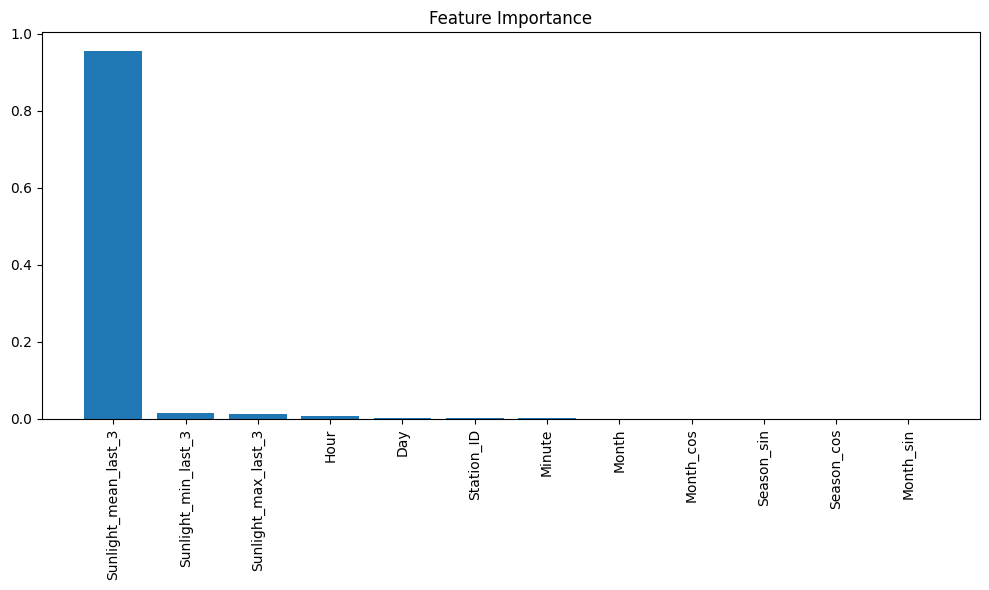

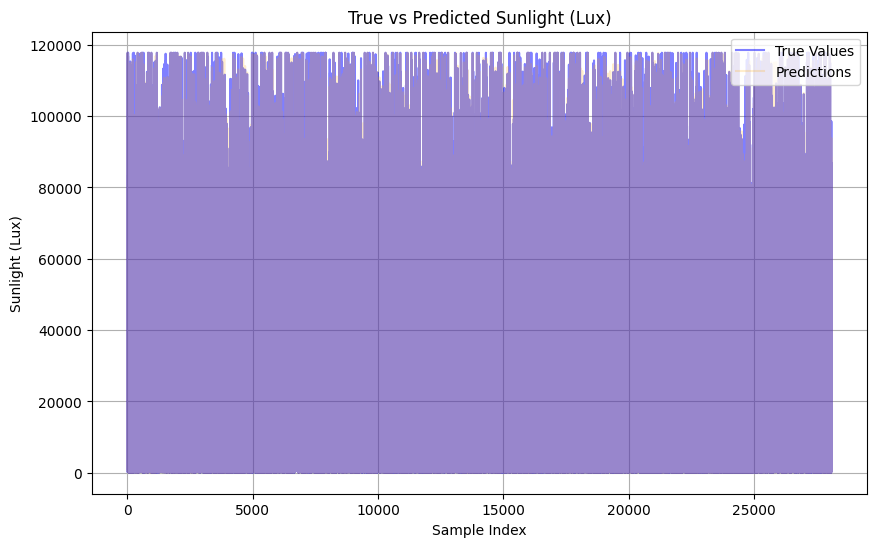

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed(42)

# 1. 数据预处理
def prepare_data(file_path):
    # 读取数据
    data = pd.read_csv(file_path)
    
    # 生成时间相关特征
    data['Season_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['Season_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
    
    # 滚动统计特征
    data['Sunlight_mean_last_3'] = data['Sunlight(Lux)'].rolling(window=3).mean()
    data['Sunlight_max_last_3'] = data['Sunlight(Lux)'].rolling(window=3).max()
    data['Sunlight_min_last_3'] = data['Sunlight(Lux)'].rolling(window=3).min()
    
    # 填充缺失值
    data.fillna(method='bfill', inplace=True)
    
    # 选择特征和目标值
    features = [
        'Month', 'Day', 'Hour', 'Minute', 'Station_ID',
        'Month_sin', 'Month_cos', 'Season_sin', 'Season_cos',
        'Sunlight_mean_last_3', 'Sunlight_max_last_3', 'Sunlight_min_last_3'
    ]
    X = data[features]
    y = data['Sunlight(Lux)']
    
    return X, y, features

# 2. 数据标准化与分割
def scale_and_split_data(X, y):
    # 特征归一化
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 目标值归一化
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))
    
    # 数据集划分
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler, target_scaler

# 3. 模型训练与优化
def train_random_forest(X_train, y_train):
    # 简单的随机森林参数设置
    rf_model = RandomForestRegressor(
        n_estimators=200,  # 树的数量
        random_state=42
    )
    rf_model.fit(X_train, y_train.ravel())
    return rf_model

# 4. 模型评估
def evaluate_model(model, X_test, y_test, target_scaler):
    # 模型预测
    y_pred = model.predict(X_test)
    
    # 反归一化目标值
    y_test_original = target_scaler.inverse_transform(y_test)
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    # 计算评估指标
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return y_test_original, y_pred_original

# 5. 可视化特征重要性
def plot_feature_importance(model, feature_names):
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.bar(
        range(len(feature_names)), 
        feature_importances[sorted_indices],
        align="center"
    )
    plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_indices], rotation=90)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

# 6. 预测结果可视化
def plot_predictions(y_test_original, y_pred_original):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original, label="True Values", color='blue', alpha=0.5)
    plt.plot(y_pred_original, label="Predictions", color='orange', alpha=0.2)
    plt.xlabel("Sample Index")
    plt.ylabel("Sunlight (Lux)")
    plt.title("True vs Predicted Sunlight (Lux)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 7. 主函数
if __name__ == "__main__":
    # 数据加载与预处理
    data_path = "/home/s312657018/TBrain/data-preprocess/All_min_Training_Data.csv"
    X, y, features = prepare_data(data_path)
    
    # 数据归一化与划分
    X_train, X_test, y_train, y_test, scaler, target_scaler = scale_and_split_data(X, y)
    
    # 模型训练与优化
    rf_model = train_random_forest(X_train, y_train)
    
    # 模型评估
    y_test_original, y_pred_original = evaluate_model(rf_model, X_test, y_test, target_scaler)
    
    # 可视化特征重要性
    plot_feature_importance(rf_model, features)
    
    # 可视化预测结果
    plot_predictions(y_test_original, y_pred_original)


In [95]:
from datetime import datetime
def process_serial(df, serial_column_name):
    # Convert serial to datetime format
    df['Serial'] = df[serial_column_name]
    df['Datetime'] = df[serial_column_name].astype(str).apply(lambda x: datetime.strptime(x[:12], '%Y%m%d%H%M'))
    df['Date'] = df['Datetime'].dt.date
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute
    df['Station_ID'] = df[serial_column_name].astype(str).str[-2:].astype(int)  # 提取後兩碼作為序列代號
    
    # Add sine and cosine encoding for periodic features
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  # 假设最大 31 天
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
    df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)
    df['Season_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Season_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    
    if 'Sunlight(Lux)' in df.columns:
        df['Sunlight_mean_last_3'] = df['Sunlight(Lux)'].rolling(window=3).mean()
    
    # Generate interaction features
    if 'WindSpeed(m/s)' in df.columns and 'Sunlight(Lux)' in df.columns:
        df['WindSpeed(m/s)_x_Sunlight(Lux)'] = df['WindSpeed(m/s)'] * df['Sunlight(Lux)']
    if 'Temperature(°C)' in df.columns and 'Sunlight(Lux)' in df.columns:
        df['Temperature(°C)_x_Sunlight(Lux)'] = df['Temperature(°C)'] * df['Sunlight(Lux)']
    
    return df

test_data = pd.read_csv('/home/s312657018/TBrain/code/process_upload.csv')
test_data = process_serial(test_data, '序號')

In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# 1. 定义函数：使用随机森林填充缺失特征
def fill_missing_features(train_data, test_data, features_to_fill, input_features):
    """
    使用随机森林填充测试集缺失特征，保留测试集原始列
    :param train_data: 训练数据（完整的特征和目标值）
    :param test_data: 测试数据（包含需要填充的缺失特征）
    :param features_to_fill: 需要填充的特征名称列表
    :param input_features: 用于预测的输入特征名称列表
    :return: 填充后的测试数据（保留原始列，并添加填充后的特征列）
    """
    # 初始化 scaler
    input_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # 对输入特征进行标准化（训练集）
    X_train = train_data[input_features]
    X_train_scaled = input_scaler.fit_transform(X_train)  # 用训练集拟合 scaler
    
    # 初始化一个 DataFrame 保存填充的特征
    filled_features = pd.DataFrame(index=test_data.index)

    for target_feature in features_to_fill:
        print(f"Training model to fill feature: {target_feature}")
        
        # 提取目标特征并进行标准化
        y_train = train_data[target_feature].values.reshape(-1, 1)
        y_train_scaled = target_scaler.fit_transform(y_train)
        
        # 初始化随机森林模型并训练
        rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
        rf_model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 标准化测试集
        X_test = test_data[input_features]
        X_test_scaled = input_scaler.transform(X_test)  # 使用训练集的 scaler
        
        # 预测测试集目标特征的标准化值
        predicted_values_scaled = rf_model.predict(X_test_scaled)
        
        # 反标准化预测值
        predicted_values = target_scaler.inverse_transform(predicted_values_scaled.reshape(-1, 1))
        
        # 将填充的特征添加到新 DataFrame
        filled_features[target_feature] = predicted_values.flatten()
    
    # 合并原始测试数据和填充的新特征列
    test_data_filled = pd.concat([test_data, filled_features], axis=1)
    
    return test_data_filled


# 2. 准备数据
# 假设 `data` 为训练集，`test_data` 为测试集
# data['Season_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
# data['Season_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# 定义需要填充的特征和输入特征
features_to_fill = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)']  # 测试集中需要填充的特征
input_features = [
    'Day', 'Minute', 'Station_ID', 
    'Month_sin', 'Month_cos', 'Season_sin', 'Season_cos', 'Hour_sin', 'Hour_cos'
]

# 确保 `test_data` 包含原始列
train_data = data_with_time_features[input_features + features_to_fill]
# test_data = test_data_with_stats.copy()  # 防止覆盖原始测试集
test_data = test_data.copy()

# 3. 使用随机森林填充测试集的缺失特征
test_data_filled = fill_missing_features(train_data, test_data, features_to_fill, input_features)

# 4. 保存填充后的测试集（包括原始列和填充后的列）
# test_data_filled.to_csv("competiton_test_features_filled.csv", index=False)
# print("Filled test features saved to 'competiton_test_features_filled.csv'")


Training model to fill feature: WindSpeed(m/s)
Training model to fill feature: Pressure(hpa)
Training model to fill feature: Temperature(°C)
Training model to fill feature: Humidity(%)
Training model to fill feature: Sunlight(Lux)
Training model to fill feature: Power(mW)


In [ ]:
test_data_filled = np.round(test_data_filled, 2)
test_data_filled

In [13]:
result_df = pd.DataFrame({
        '序號': test_data_filled.iloc[:, 0],
        '答案': test_data_filled.iloc[:, -1]
    })
result_df.to_csv('test_results.csv', index=False)
print("Test results saved to 'test_results.csv'")

Test results saved to 'test_results.csv'


### 添加 Sunlight 三天個時段的的平均

In [3]:
import pandas as pd
import numpy as np

def calculate_past_statistics(train_data, test_data, datetime_col, target_col, station_col):
    """
    為測試集中的每個時間點，計算相同 Station_ID 的最近三筆數據的統計特徵。
    - 第 1 笔：从训练集获取最近 3 笔。
    - 第 2 笔：从训练集获取最近 2 笔，结合测试集中第 1 笔。
    - 第 3 笔：从训练集获取最近 1 笔，结合测试集中第 1、2 笔。
    - 第 4 笔及以后：动态从训练集和测试集中获取最近 3 笔记录。
    
    :param train_data: 訓練集（包含時間列、目標列和站點 ID）
    :param test_data: 測試集（包含時間列和站點 ID）
    :param datetime_col: 時間列名稱
    :param target_col: 目標列名稱
    :param station_col: 站點 ID 列名稱
    :return: 添加統計特徵後的測試集
    """
    # 確保時間列為 datetime 格式
    train_data[datetime_col] = pd.to_datetime(train_data[datetime_col])
    test_data[datetime_col] = pd.to_datetime(test_data[datetime_col])
    
    # 初始化存放統計特徵的列表
    sunlight_means = []
    sunlight_buffer = {station: [] for station in test_data[station_col].unique()}  # 按 Station_ID 存储最近的值

    # 遍歷測試集的每個時間點
    for idx, row in test_data.iterrows():
        test_time = row[datetime_col]
        station_id = row[station_col]
        
        # 从训练集中获取相同 Station_ID 的数据，按时间排序
        station_data = train_data[train_data[station_col] == station_id]
        station_data = station_data[station_data[datetime_col] < test_time].sort_values(by=datetime_col, ascending=False)
        
        # 获取当前 buffer 的内容（已在测试集中生成的记录）
        current_buffer = sunlight_buffer[station_id]
        
        if len(current_buffer) < 3:
            # 从训练集中补足最近的记录
            needed = 3 - len(current_buffer)
            recent_train_data = station_data.head(needed)[target_col].tolist()
            recent_data = recent_train_data + current_buffer
        else:
            # 从测试集的 buffer 中获取最近 3 条记录
            recent_data = current_buffer[:3]
        
        # 如果有數據，計算均值，否則記錄 NaN
        mean_value = np.mean(recent_data) if recent_data else np.nan
        sunlight_means.append(mean_value)
        
        # 更新 buffer：始终保存最新的记录
        sunlight_buffer[station_id] = [mean_value] + sunlight_buffer[station_id]

    # 將計算的均值加入到測試數據
    test_data['Sunlight_mean_last_3'] = sunlight_means
    
    return test_data

# 示例调用
train_data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/All_min_Training_Data.csv')
test_data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/competiton_test_features_filled.csv')

# 確保時間與站點對應唯一
train_data = train_data.drop_duplicates(subset=['Datetime', 'Station_ID'])

# 執行處理
test_data_with_stats = calculate_past_statistics(
    train_data=train_data, 
    test_data=test_data, 
    datetime_col='Datetime', 
    target_col='Power(mW)',
    station_col='Station_ID'
)

# 保存结果
# test_data_with_stats.to_csv("test_data_with_stats.csv", index=False)
# print("Updated test data with statistics saved to 'test_data_with_stats.csv'")
test_data_with_stats

,序號,答案,Serial,Datetime,Date,Year,Month,Day,Hour,Minute,...,Minute_cos,Season_sin,Season_cos,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Sunlight_mean_last_3
0,20240117090001,NaN,20240117090001,2024-01-17 09:00:00,2024-01-17,2024,1,17,9,0,...,1.0,0.500000,0.866025,0.22040,1017.75245,19.37475,56.53675,74938.64145,1126.03475,74.873333
1,20240117091001,NaN,20240117091001,2024-01-17 09:10:00,2024-01-17,2024,1,17,9,10,...,0.5,0.500000,0.866025,0.34180,1017.79330,19.42065,51.25650,77016.78110,969.31015,81.351111
2,20240117092001,NaN,20240117092001,2024-01-17 09:20:00,2024-01-17,2024,1,17,9,20,...,-0.5,0.500000,0.866025,0.51535,1017.79805,19.63340,48.76150,84519.93075,1491.66750,84.471481
3,20240117093001,NaN,20240117093001,2024-01-17 09:30:00,2024-01-17,2024,1,17,9,30,...,-1.0,0.500000,0.866025,0.49765,1017.81695,20.04085,46.58595,89150.57090,1537.55395,80.231975
4,20240117094001,NaN,20240117094001,2024-01-17 09:40:00,2024-01-17,2024,1,17,9,40,...,-0.5,0.500000,0.866025,0.63225,1017.83590,20.15630,45.23650,92477.72615,1437.73640,82.018189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,20241002161012,NaN,20241002161012,2024-10-02 16:10:00,2024-10-02,2024,10,2,16,10,...,0.5,-0.866025,0.500000,0.00000,1005.40895,25.49535,100.00000,5473.89525,11.32650,14.796667
9596,20241002162012,NaN,20241002162012,2024-10-02 16:20:00,2024-10-02,2024,10,2,16,20,...,-0.5,-0.866025,0.500000,0.00000,1005.31885,25.63495,100.00000,5127.00365,8.05795,14.796667
9597,20241002163012,NaN,20241002163012,2024-10-02 16:30:00,2024-10-02,2024,10,2,16,30,...,-1.0,-0.866025,0.500000,0.00000,1005.14130,25.56365,100.00000,3304.66065,5.44225,14.796667
9598,20241002164012,NaN,20241002164012,2024-10-02 16:40:00,2024-10-02,2024,10,2,16,40,...,-0.5,-0.866025,0.500000,0.00000,1005.21975,25.58935,100.00000,1902.24600,3.44890,14.796667


In [ ]:
time_features = ['Month', 'Day', 'Hour', 'Minute', 'Station_ID', 'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos', 'Season_sin', 'Season_cos',
                 'WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']

target_columns = ['Power(mW)']
train_features = data[time_features]  # 假设 X 是您训练时使用的数据
models = {}
for target in target_columns:
    rf_model = RandomForestRegressor(random_state=42, n_estimators=200)
    rf_model.fit(train_features, data[target])
    models[target] = rf_model
    test_data_with_stats[target] = rf_model.predict(test_data_with_stats[time_features])

In [127]:
test_data_with_stats

,序號,答案,Serial,Datetime,Date,Year,Month,Day,Hour,Minute,...,Minute_cos,Season_sin,Season_cos,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),Sunlight_mean_last_3
0,20240117090001,NaN,20240117090001,2024-01-17 09:00:00,2024-01-17,2024,1,17,9,0,...,1.0,0.500000,0.866025,0.22040,1017.75245,19.37475,56.53675,74938.64145,1174.62985,18243.000000
1,20240117091001,NaN,20240117091001,2024-01-17 09:10:00,2024-01-17,2024,1,17,9,10,...,0.5,0.500000,0.866025,0.34180,1017.79330,19.42065,51.25650,77016.78110,1239.60755,18243.000000
2,20240117092001,NaN,20240117092001,2024-01-17 09:20:00,2024-01-17,2024,1,17,9,20,...,-0.5,0.500000,0.866025,0.51535,1017.79805,19.63340,48.76150,84519.93075,1378.20630,18243.000000
3,20240117093001,NaN,20240117093001,2024-01-17 09:30:00,2024-01-17,2024,1,17,9,30,...,-1.0,0.500000,0.866025,0.49765,1017.81695,20.04085,46.58595,89150.57090,1235.63715,18243.000000
4,20240117094001,NaN,20240117094001,2024-01-17 09:40:00,2024-01-17,2024,1,17,9,40,...,-0.5,0.500000,0.866025,0.63225,1017.83590,20.15630,45.23650,92477.72615,1201.65950,18243.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,20241002161012,NaN,20241002161012,2024-10-02 16:10:00,2024-10-02,2024,10,2,16,10,...,0.5,-0.866025,0.500000,0.00000,1005.40895,25.49535,100.00000,5473.89525,13.15035,8060.803333
9596,20241002162012,NaN,20241002162012,2024-10-02 16:20:00,2024-10-02,2024,10,2,16,20,...,-0.5,-0.866025,0.500000,0.00000,1005.31885,25.63495,100.00000,5127.00365,11.99665,8060.803333
9597,20241002163012,NaN,20241002163012,2024-10-02 16:30:00,2024-10-02,2024,10,2,16,30,...,-1.0,-0.866025,0.500000,0.00000,1005.14130,25.56365,100.00000,3304.66065,5.45550,8060.803333
9598,20241002164012,NaN,20241002164012,2024-10-02 16:40:00,2024-10-02,2024,10,2,16,40,...,-0.5,-0.866025,0.500000,0.00000,1005.21975,25.58935,100.00000,1902.24600,1.93510,8060.803333


In [ ]:
result_df = pd.concat(
    [test_data[['Serial', 'Date', '答案', 'Datetime', 'Station_ID']], test_data_filled],  # 将 serial 和 Date 与填充后的数据拼接
    axis=1  
)

# result_df.to_csv("test_features_filled.csv", index=False)
# print("Filled test features saved to 'test_features_filled.csv'")
result_df

,Serial,Date,答案,Datetime,Station_ID,Month,Day,Hour,Minute,Station_ID,...,Season_sin,Season_cos,Hour_sin,Hour_cos,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,20240102090001,2024-01-02,1277.55,2024-01-02 09:00:00,1,1,17,9,0,1,...,0.500000,0.866025,0.707107,-0.707107,0.22040,1017.75245,19.37475,56.53675,74938.64145,1126.03475
1,20240102091001,2024-01-02,1369.80,2024-01-02 09:10:00,1,1,17,9,10,1,...,0.500000,0.866025,0.707107,-0.707107,0.34180,1017.79330,19.42065,51.25650,77016.78110,969.31015
2,20240102092001,2024-01-02,1462.67,2024-01-02 09:20:00,1,1,17,9,20,1,...,0.500000,0.866025,0.707107,-0.707107,0.51535,1017.79805,19.63340,48.76150,84519.93075,1491.66750
3,20240102093001,2024-01-02,1540.40,2024-01-02 09:30:00,1,1,17,9,30,1,...,0.500000,0.866025,0.707107,-0.707107,0.49765,1017.81695,20.04085,46.58595,89150.57090,1537.55395
4,20240102094001,2024-01-02,1594.30,2024-01-02 09:40:00,1,1,17,9,40,1,...,0.500000,0.866025,0.707107,-0.707107,0.63225,1017.83590,20.15630,45.23650,92477.72615,1437.73640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,20240708161017,2024-07-08,1.92,2024-07-08 16:10:00,17,10,2,16,10,12,...,-0.866025,0.500000,-0.866025,-0.500000,0.00000,1005.40895,25.49535,100.00000,5473.89525,11.32650
9596,20240708162017,2024-07-08,2.98,2024-07-08 16:20:00,17,10,2,16,20,12,...,-0.866025,0.500000,-0.866025,-0.500000,0.00000,1005.31885,25.63495,100.00000,5127.00365,8.05795
9597,20240708163017,2024-07-08,1.61,2024-07-08 16:30:00,17,10,2,16,30,12,...,-0.866025,0.500000,-0.866025,-0.500000,0.00000,1005.14130,25.56365,100.00000,3304.66065,5.44225
9598,20240708164017,2024-07-08,1.93,2024-07-08 16:40:00,17,10,2,16,40,12,...,-0.866025,0.500000,-0.866025,-0.500000,0.00000,1005.21975,25.58935,100.00000,1902.24600,3.44890


In [58]:
result_df = pd.DataFrame({
        '序號': result_df.iloc[:, 0],
        '答案': result_df.iloc[:, -1]
    })
result_df.to_csv('test_results.csv', index=False)
print("Test results saved to 'test_results.csv'")

Test results saved to 'test_results.csv'


-----
#### Grid Search

In [16]:
regressor_models = {
    'RandomForest1': RandomForestRegressor(random_state=42, n_estimators=300),
    'RandomForest2': RandomForestRegressor(random_state=42, n_estimators=100),
    'RandomForest3': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10),
    'RandomForest4': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=5),
}

In [17]:
completion_results = evaluate_feature_completion(X_train, X_valid, features, target_columns, time_features)


Testing feature completion with RandomForest1...
RandomForest1 - MSE for WindSpeed(m/s): 0.1096
RandomForest1 - MSE for Temperature(°C): 0.0192
RandomForest1 - MSE for Sunlight(Lux): 0.0792
RandomForest1 - MSE for WindSpeed(m/s)_x_Sunlight(Lux): 0.1332
RandomForest1 - MSE for Temperature(°C)_x_Sunlight(Lux): 0.0695
RandomForest1 - Average MSE across all features: 0.0821
Testing feature completion with RandomForest2...
RandomForest2 - MSE for WindSpeed(m/s): 0.1104
RandomForest2 - MSE for Temperature(°C): 0.0196
RandomForest2 - MSE for Sunlight(Lux): 0.0799
RandomForest2 - MSE for WindSpeed(m/s)_x_Sunlight(Lux): 0.1329
RandomForest2 - MSE for Temperature(°C)_x_Sunlight(Lux): 0.0701
RandomForest2 - Average MSE across all features: 0.0826
Testing feature completion with RandomForest3...
RandomForest3 - MSE for WindSpeed(m/s): 0.2737
RandomForest3 - MSE for Temperature(°C): 0.1767
RandomForest3 - MSE for Sunlight(Lux): 0.3615
RandomForest3 - MSE for WindSpeed(m/s)_x_Sunlight(Lux): 0.3893
R

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
import pandas as pd

# 1. 定义回归模型
regressor_models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
}

def evaluate_feature_completion(X_train, X_valid, features, target_columns, time_features):
    # 保存不同回归模型的补全效果
    completion_results = {}

    # 逐个回归模型测试
    for model_name, regressor in regressor_models.items():
        print(f"Testing feature completion with {model_name}...")

        # 存储补全特征的 DataFrame
        X_valid_pred = X_valid.copy()
        
        # 使用 time_features 作为特征来补全 target_columns
        train_features = X_train[time_features]
        valid_features = X_valid[time_features]
        
        errors = {}  # 存储每个目标特征的补全误差
        
        # 仅补全原始目标特征，不包括乘积特征
        for target in original_target_columns:
            regressor.fit(train_features, X_train[target])
            X_valid_pred[target] = regressor.predict(valid_features)
            mse = mean_squared_error(X_valid[target], X_valid_pred[target])
            errors[target] = mse
            print(f"{model_name} - MSE for {target}: {mse:.4f}")

        # 计算乘积特征的误差（如果需要）
        for product in product_columns:
            factors = product.split('_x_')
            X_valid_pred[product] = X_valid_pred[factors[0]] * X_valid_pred[factors[1]]
            mse = mean_squared_error(X_valid[product], X_valid_pred[product])
            errors[product] = mse
            print(f"{model_name} - MSE for {product}: {mse:.4f}")

        # 计算该模型的总体补全误差
        avg_mse = np.mean(list(errors.values()))
        completion_results[model_name] = {'MSE': errors, 'Avg MSE': avg_mse}
        print(f"{model_name} - Average MSE across all features: {avg_mse:.4f}")
    
    return completion_results

# 2. 数据加载和预处理
data = pd.read_csv('/home/s312657018/TBrain/data-preprocess/AvgDATA.csv')
time_features = ['Month', 'Day', 'Hour', 'Minute', 'Station_ID']
features = ['WindSpeed(m/s)', 'Temperature(°C)', 'Sunlight(Lux)',
            'WindSpeed(m/s)_x_Sunlight(Lux)', 'Temperature(°C)_x_Sunlight(Lux)',
            'Month', 'Day', 'Hour', 'Minute', 'Station_ID']
target_columns = [col for col in features if col not in time_features]
original_target_columns = ['WindSpeed(m/s)', 'Temperature(°C)', 'Sunlight(Lux)']
product_columns = ['WindSpeed(m/s)_x_Sunlight(Lux)', 'Temperature(°C)_x_Sunlight(Lux)']

# 3. 分割数据集
X = data[features]
y = data['Power(mW)']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# 4. 标准化
scaler = StandardScaler()
X_train[original_target_columns] = scaler.fit_transform(X_train[original_target_columns])
X_valid[original_target_columns] = scaler.transform(X_valid[original_target_columns])

# 5. 评估特征补全效果
completion_results = evaluate_feature_completion(X_train, X_valid, features, target_columns, time_features)

# 输出结果
print("Feature completion results:\n", completion_results)


Testing feature completion with RandomForest...
RandomForest - MSE for WindSpeed(m/s): 0.1004
RandomForest - MSE for Temperature(°C): 0.0206
RandomForest - MSE for Sunlight(Lux): 0.0834
RandomForest - MSE for WindSpeed(m/s)_x_Sunlight(Lux): 2109389575.6678
RandomForest - MSE for Temperature(°C)_x_Sunlight(Lux): 3464337008088.7280
RandomForest - Average MSE across all features: 693289279532.9200
Feature completion results:
 {'RandomForest': {'MSE': {'WindSpeed(m/s)': np.float64(0.10040393898269438), 'Temperature(°C)': np.float64(0.020609487053280445), 'Sunlight(Lux)': np.float64(0.08337994321345758), 'WindSpeed(m/s)_x_Sunlight(Lux)': np.float64(2109389575.6677878), 'Temperature(°C)_x_Sunlight(Lux)': np.float64(3464337008088.728)}, 'Avg MSE': np.float64(693289279532.92)}}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def fill_missing_features_with_validation(train_data, validation_data, test_data, features_to_fill, input_features):
    """
    使用隨機森林填補測試及特徵，同時在訓練過程中使用驗證集評估。
    """
    # 初始化 scaler
    input_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # 對訓練集做標準化
    X_train = train_data[input_features]
    X_train_scaled = input_scaler.fit_transform(X_train)  # 用训练集拟合 scaler

    filled_features = pd.DataFrame(index=test_data.index)

    for target_feature in features_to_fill:
        print(f"Training model to fill feature: {target_feature}")

        y_train = train_data[target_feature].values.reshape(-1, 1)
        y_train_scaled = target_scaler.fit_transform(y_train)
        
        rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
        rf_model.fit(X_train_scaled, y_train_scaled.ravel())

        X_valid = validation_data[input_features]
        y_valid = validation_data[target_feature].values.reshape(-1, 1)
        X_valid_scaled = input_scaler.transform(X_valid)  # 标准化验证集
        y_valid_scaled = target_scaler.transform(y_valid)

        y_valid_pred_scaled = rf_model.predict(X_valid_scaled)
        y_valid_pred = target_scaler.inverse_transform(y_valid_pred_scaled.reshape(-1, 1))

        mse = mean_squared_error(y_valid, y_valid_pred)
        mae = mean_absolute_error(y_valid, y_valid_pred)
        r2 = r2_score(y_valid, y_valid_pred)
        score = abs(y_valid - y_valid_pred).sum()
        print(f"Validation MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, score: {score}")

        X_test = test_data[input_features]
        X_test_scaled = input_scaler.transform(X_test)  # 使用训练集的 scaler

        predicted_values_scaled = rf_model.predict(X_test_scaled)
        predicted_values = target_scaler.inverse_transform(predicted_values_scaled.reshape(-1, 1))

        # 把填充的特徵加到DataFrame
        filled_features[target_feature] = predicted_values.flatten()

    test_data_filled = pd.concat([test_data, filled_features], axis=1)
    score = abs(test_data_filled['答案'] - test_data_filled['Power(mW)']).sum()
    print(f'score: {score}')

    return test_data_filled

# 定義要填充的特徵變數
features_to_fill = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)']
input_features = [
    'Month', 'Day', 'Hour', 'Minute', 'Station_ID',
    'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos'
]

# test_data = pd.read_csv('/path/to/your/test_data.csv')

test_data_filled = fill_missing_features_with_validation(
    train_data=train_set,
    validation_data=validation_set,
    test_data=test_data,
    features_to_fill=features_to_fill,
    input_features=input_features
)

# 保存結果
# test_data_filled.to_csv("competiton_test_features_filled.csv", index=False)
# print("Filled test features saved to 'competiton_test_features_filled.csv'")


Training model to fill feature: WindSpeed(m/s)
Validation MSE: 0.0464, MAE: 0.0719, R2: 0.9321, score: 621.4278500000003
Training model to fill feature: Pressure(hpa)
Validation MSE: 0.0613, MAE: 0.0674, R2: 0.9983, score: 583.0756499999932
Training model to fill feature: Temperature(°C)
Validation MSE: 0.2884, MAE: 0.2939, R2: 0.9965, score: 2541.323050000006
Training model to fill feature: Humidity(%)
Validation MSE: 24.6328, MAE: 1.3947, R2: 0.9608, score: 12061.024150000028
Training model to fill feature: Sunlight(Lux)
Validation MSE: 34898920.9064, MAE: 2152.8673, R2: 0.9624, score: 18617996.553950015
Training model to fill feature: Power(mW)
Validation MSE: 9263.4981, MAE: 32.3016, R2: 0.9667, score: 279344.07905000006
score: 281492.97465000005
